In [1]:
# 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''알고리즘 관련 라이브러리'''
import lightgbm as lgb

'''텐서플로 및 케라스 관련 라이브러리'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


In [2]:
# 데이터 로드
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()

# 데이터 스케일
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

# 훈련 및 테스트 셋 분할
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [3]:
# 훈련 셋으로부터 레이블 90% 제거

toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

C:\Users\Surface Pro6\.conda\envs\unsupervisedLearning\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
# 평가 함수(이상치 스코어 함수) 및 그래프 함수 정의

In [5]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [6]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

In [7]:
# 특정 재현율 임계점별 정밀도를 평가하기 위한 새로운 함수 정의

In [8]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

In [9]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [10]:
# 지도 학습

In [11]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [12]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00397338
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00513171
[3]	valid_0's binary_logloss: 0.00603679
[4]	valid_0's binary_logloss: 0.00702635
[5]	valid_0's binary_logloss: 0.00614841
[6]	valid_0's binary_logloss: 0.00512317
[7]	valid_0's binary_logloss: 0.0123727
[8]	valid_0's binary_logloss: 0.00511973
[9]	valid_0's binary_logloss: 0.00818307
[10]	valid_0's binary_logloss: 0.00897806
[11]	valid_0's binary_logloss: 0.00866636
[12]	valid_0's binary_logloss: 0.00867258
[13]	valid_0's binary_logloss: 0.0086395
[14]	valid_0's binary_logloss: 0.00801609
[15]	valid_0's binary_logloss: 0.0074302
[16]	valid_0's binary_logloss: 0.00966375
[17]	valid_0's binary_logloss: 0.0107584
[18]	valid_0's binary_logloss: 0.00982517
[19]	valid_0's binary_logloss: 0.00960756
[20]	valid_0's binary_logloss: 0.00888414
[21]	valid_0's binary_logloss: 0.0108164
[22]	valid_0's binary_logloss: 0.0101935
[23]	valid_0's binary_loglos

[201]	valid_0's binary_logloss: 0.00664893
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00397338
Training Log Loss:  0.00291511439028313
CV Log Loss:  0.003973378525319735
[1]	valid_0's binary_logloss: 0.00426885
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00425831
[3]	valid_0's binary_logloss: 0.00424682
[4]	valid_0's binary_logloss: 0.00423358
[5]	valid_0's binary_logloss: 0.00421715
[6]	valid_0's binary_logloss: 0.00419369
[7]	valid_0's binary_logloss: 0.00420494
[8]	valid_0's binary_logloss: 0.00466448
[9]	valid_0's binary_logloss: 0.00414474
[10]	valid_0's binary_logloss: 0.00413083
[11]	valid_0's binary_logloss: 0.0041182
[12]	valid_0's binary_logloss: 0.0041067
[13]	valid_0's binary_logloss: 0.00409612
[14]	valid_0's binary_logloss: 0.00408637
[15]	valid_0's binary_logloss: 0.00407721
[16]	valid_0's binary_logloss: 0.00406861
[17]	valid_0's binary_logloss: 0.00406054
[18]	valid_0's binary_logloss: 0.0040528

[200]	valid_0's binary_logloss: 0.00365514
[201]	valid_0's binary_logloss: 0.00365469
[202]	valid_0's binary_logloss: 0.0036545
[203]	valid_0's binary_logloss: 0.00365441
[204]	valid_0's binary_logloss: 0.00365361
[205]	valid_0's binary_logloss: 0.0036535
[206]	valid_0's binary_logloss: 0.00365333
[207]	valid_0's binary_logloss: 0.0036529
[208]	valid_0's binary_logloss: 0.00365274
[209]	valid_0's binary_logloss: 0.00365264
[210]	valid_0's binary_logloss: 0.00365187
[211]	valid_0's binary_logloss: 0.00365172
[212]	valid_0's binary_logloss: 0.00365163
[213]	valid_0's binary_logloss: 0.00365149
[214]	valid_0's binary_logloss: 0.00365107
[215]	valid_0's binary_logloss: 0.00365098
[216]	valid_0's binary_logloss: 0.00365057
[217]	valid_0's binary_logloss: 0.00365015
[218]	valid_0's binary_logloss: 0.00364975
[219]	valid_0's binary_logloss: 0.00364995
[220]	valid_0's binary_logloss: 0.00364988
[221]	valid_0's binary_logloss: 0.00364977
[222]	valid_0's binary_logloss: 0.00364982
[223]	valid_0'

[399]	valid_0's binary_logloss: 0.00360672
[400]	valid_0's binary_logloss: 0.00360687
[401]	valid_0's binary_logloss: 0.00360654
[402]	valid_0's binary_logloss: 0.00360621
[403]	valid_0's binary_logloss: 0.00360637
[404]	valid_0's binary_logloss: 0.00360595
[405]	valid_0's binary_logloss: 0.00360559
[406]	valid_0's binary_logloss: 0.00360526
[407]	valid_0's binary_logloss: 0.00360541
[408]	valid_0's binary_logloss: 0.00360499
[409]	valid_0's binary_logloss: 0.00360514
[410]	valid_0's binary_logloss: 0.00360434
[411]	valid_0's binary_logloss: 0.00360393
[412]	valid_0's binary_logloss: 0.0036041
[413]	valid_0's binary_logloss: 0.00360394
[414]	valid_0's binary_logloss: 0.00360362
[415]	valid_0's binary_logloss: 0.00360326
[416]	valid_0's binary_logloss: 0.00360247
[417]	valid_0's binary_logloss: 0.00360207
[418]	valid_0's binary_logloss: 0.00360223
[419]	valid_0's binary_logloss: 0.00360181
[420]	valid_0's binary_logloss: 0.00360197
[421]	valid_0's binary_logloss: 0.00360119
[422]	valid_

[592]	valid_0's binary_logloss: 0.00360136
[593]	valid_0's binary_logloss: 0.00360091
[594]	valid_0's binary_logloss: 0.00360054
[595]	valid_0's binary_logloss: 0.00360066
[596]	valid_0's binary_logloss: 0.00360029
[597]	valid_0's binary_logloss: 0.00359991
[598]	valid_0's binary_logloss: 0.00359954
[599]	valid_0's binary_logloss: 0.00359925
[600]	valid_0's binary_logloss: 0.003599
[601]	valid_0's binary_logloss: 0.00359923
[602]	valid_0's binary_logloss: 0.00359974
[603]	valid_0's binary_logloss: 0.00359944
[604]	valid_0's binary_logloss: 0.00359908
[605]	valid_0's binary_logloss: 0.0035994
[606]	valid_0's binary_logloss: 0.00359907
[607]	valid_0's binary_logloss: 0.0035994
[608]	valid_0's binary_logloss: 0.00359895
[609]	valid_0's binary_logloss: 0.00359881
[610]	valid_0's binary_logloss: 0.00359843
[611]	valid_0's binary_logloss: 0.00359806
[612]	valid_0's binary_logloss: 0.00359762
[613]	valid_0's binary_logloss: 0.00359725
[614]	valid_0's binary_logloss: 0.00359688
[615]	valid_0's

[791]	valid_0's binary_logloss: 0.00355594
[792]	valid_0's binary_logloss: 0.00355527
[793]	valid_0's binary_logloss: 0.00355541
[794]	valid_0's binary_logloss: 0.00355474
[795]	valid_0's binary_logloss: 0.0035536
[796]	valid_0's binary_logloss: 0.00355393
[797]	valid_0's binary_logloss: 0.00355327
[798]	valid_0's binary_logloss: 0.00355213
[799]	valid_0's binary_logloss: 0.00355226
[800]	valid_0's binary_logloss: 0.0035516
[801]	valid_0's binary_logloss: 0.00355174
[802]	valid_0's binary_logloss: 0.0035506
[803]	valid_0's binary_logloss: 0.00354994
[804]	valid_0's binary_logloss: 0.00355036
[805]	valid_0's binary_logloss: 0.00355142
[806]	valid_0's binary_logloss: 0.00355076
[807]	valid_0's binary_logloss: 0.0035509
[808]	valid_0's binary_logloss: 0.00355024
[809]	valid_0's binary_logloss: 0.0035491
[810]	valid_0's binary_logloss: 0.00354924
[811]	valid_0's binary_logloss: 0.00354951
[812]	valid_0's binary_logloss: 0.00354836
[813]	valid_0's binary_logloss: 0.00354851
[814]	valid_0's 

[988]	valid_0's binary_logloss: 0.00358386
[989]	valid_0's binary_logloss: 0.00358488
[990]	valid_0's binary_logloss: 0.00358378
[991]	valid_0's binary_logloss: 0.00358354
[992]	valid_0's binary_logloss: 0.00358417
[993]	valid_0's binary_logloss: 0.00358494
[994]	valid_0's binary_logloss: 0.00358495
[995]	valid_0's binary_logloss: 0.00358601
[996]	valid_0's binary_logloss: 0.00358679
[997]	valid_0's binary_logloss: 0.00358655
[998]	valid_0's binary_logloss: 0.00358757
[999]	valid_0's binary_logloss: 0.00358821
[1000]	valid_0's binary_logloss: 0.00358822
[1001]	valid_0's binary_logloss: 0.00358897
[1002]	valid_0's binary_logloss: 0.00359003
[1003]	valid_0's binary_logloss: 0.00358979
[1004]	valid_0's binary_logloss: 0.00359081
[1005]	valid_0's binary_logloss: 0.00359187
[1006]	valid_0's binary_logloss: 0.00359264
[1007]	valid_0's binary_logloss: 0.00359251
[1008]	valid_0's binary_logloss: 0.00359314
[1009]	valid_0's binary_logloss: 0.00359397
[1010]	valid_0's binary_logloss: 0.00359373


[132]	valid_0's binary_logloss: 0.00323424
[133]	valid_0's binary_logloss: 0.00322996
[134]	valid_0's binary_logloss: 0.00322496
[135]	valid_0's binary_logloss: 0.00322002
[136]	valid_0's binary_logloss: 0.0032152
[137]	valid_0's binary_logloss: 0.00321088
[138]	valid_0's binary_logloss: 0.00320627
[139]	valid_0's binary_logloss: 0.0032018
[140]	valid_0's binary_logloss: 0.00319668
[141]	valid_0's binary_logloss: 0.00319224
[142]	valid_0's binary_logloss: 0.003188
[143]	valid_0's binary_logloss: 0.00318368
[144]	valid_0's binary_logloss: 0.00317943
[145]	valid_0's binary_logloss: 0.00317533
[146]	valid_0's binary_logloss: 0.00317119
[147]	valid_0's binary_logloss: 0.00316676
[148]	valid_0's binary_logloss: 0.00316278
[149]	valid_0's binary_logloss: 0.0031588
[150]	valid_0's binary_logloss: 0.00315454
[151]	valid_0's binary_logloss: 0.00315027
[152]	valid_0's binary_logloss: 0.00314604
[153]	valid_0's binary_logloss: 0.00314232
[154]	valid_0's binary_logloss: 0.00313849
[155]	valid_0's 

[332]	valid_0's binary_logloss: 0.0030947
[333]	valid_0's binary_logloss: 0.00309283
[334]	valid_0's binary_logloss: 0.00309015
[335]	valid_0's binary_logloss: 0.00308734
[336]	valid_0's binary_logloss: 0.00308551
[337]	valid_0's binary_logloss: 0.00308272
[338]	valid_0's binary_logloss: 0.0030809
[339]	valid_0's binary_logloss: 0.00307871
[340]	valid_0's binary_logloss: 0.00307617
[341]	valid_0's binary_logloss: 0.0030732
[342]	valid_0's binary_logloss: 0.00307102
[343]	valid_0's binary_logloss: 0.00306926
[344]	valid_0's binary_logloss: 0.00306669
[345]	valid_0's binary_logloss: 0.0030642
[346]	valid_0's binary_logloss: 0.00306247
[347]	valid_0's binary_logloss: 0.00306035
[348]	valid_0's binary_logloss: 0.00305789
[349]	valid_0's binary_logloss: 0.00305501
[350]	valid_0's binary_logloss: 0.00305293
[351]	valid_0's binary_logloss: 0.00305124
[352]	valid_0's binary_logloss: 0.00304874
[353]	valid_0's binary_logloss: 0.00304633
[354]	valid_0's binary_logloss: 0.00304467
[355]	valid_0's

[538]	valid_0's binary_logloss: 0.00271195
[539]	valid_0's binary_logloss: 0.00271039
[540]	valid_0's binary_logloss: 0.00270822
[541]	valid_0's binary_logloss: 0.00270604
[542]	valid_0's binary_logloss: 0.00270431
[543]	valid_0's binary_logloss: 0.00270277
[544]	valid_0's binary_logloss: 0.00270058
[545]	valid_0's binary_logloss: 0.00269951
[546]	valid_0's binary_logloss: 0.00269852
[547]	valid_0's binary_logloss: 0.00269673
[548]	valid_0's binary_logloss: 0.00269598
[549]	valid_0's binary_logloss: 0.00269457
[550]	valid_0's binary_logloss: 0.00269299
[551]	valid_0's binary_logloss: 0.00269193
[552]	valid_0's binary_logloss: 0.00269023
[553]	valid_0's binary_logloss: 0.00268807
[554]	valid_0's binary_logloss: 0.00268655
[555]	valid_0's binary_logloss: 0.0026855
[556]	valid_0's binary_logloss: 0.00268335
[557]	valid_0's binary_logloss: 0.00268158
[558]	valid_0's binary_logloss: 0.00268061
[559]	valid_0's binary_logloss: 0.00267938
[560]	valid_0's binary_logloss: 0.00267832
[561]	valid_

[733]	valid_0's binary_logloss: 0.00247144
[734]	valid_0's binary_logloss: 0.0024704
[735]	valid_0's binary_logloss: 0.00246929
[736]	valid_0's binary_logloss: 0.00246928
[737]	valid_0's binary_logloss: 0.00246824
[738]	valid_0's binary_logloss: 0.00246737
[739]	valid_0's binary_logloss: 0.00246684
[740]	valid_0's binary_logloss: 0.00246581
[741]	valid_0's binary_logloss: 0.00246581
[742]	valid_0's binary_logloss: 0.00246477
[743]	valid_0's binary_logloss: 0.00246375
[744]	valid_0's binary_logloss: 0.00246288
[745]	valid_0's binary_logloss: 0.00246282
[746]	valid_0's binary_logloss: 0.00246282
[747]	valid_0's binary_logloss: 0.0024618
[748]	valid_0's binary_logloss: 0.00246125
[749]	valid_0's binary_logloss: 0.00245941
[750]	valid_0's binary_logloss: 0.00245942
[751]	valid_0's binary_logloss: 0.00245887
[752]	valid_0's binary_logloss: 0.00245819
[753]	valid_0's binary_logloss: 0.00245734
[754]	valid_0's binary_logloss: 0.0024555
[755]	valid_0's binary_logloss: 0.0024555
[756]	valid_0's

[938]	valid_0's binary_logloss: 0.00236423
[939]	valid_0's binary_logloss: 0.00236463
[940]	valid_0's binary_logloss: 0.00236326
[941]	valid_0's binary_logloss: 0.00236202
[942]	valid_0's binary_logloss: 0.00236095
[943]	valid_0's binary_logloss: 0.0023607
[944]	valid_0's binary_logloss: 0.00236106
[945]	valid_0's binary_logloss: 0.00236113
[946]	valid_0's binary_logloss: 0.00235977
[947]	valid_0's binary_logloss: 0.00235922
[948]	valid_0's binary_logloss: 0.00235961
[949]	valid_0's binary_logloss: 0.00235839
[950]	valid_0's binary_logloss: 0.00235875
[951]	valid_0's binary_logloss: 0.00235916
[952]	valid_0's binary_logloss: 0.00235786
[953]	valid_0's binary_logloss: 0.00235732
[954]	valid_0's binary_logloss: 0.00235775
[955]	valid_0's binary_logloss: 0.0023564
[956]	valid_0's binary_logloss: 0.00235591
[957]	valid_0's binary_logloss: 0.00235469
[958]	valid_0's binary_logloss: 0.00235506
[959]	valid_0's binary_logloss: 0.00235454
[960]	valid_0's binary_logloss: 0.00235542
[961]	valid_0

[1132]	valid_0's binary_logloss: 0.00229472
[1133]	valid_0's binary_logloss: 0.00229464
[1134]	valid_0's binary_logloss: 0.00229382
[1135]	valid_0's binary_logloss: 0.00229333
[1136]	valid_0's binary_logloss: 0.002293
[1137]	valid_0's binary_logloss: 0.00229211
[1138]	valid_0's binary_logloss: 0.00229133
[1139]	valid_0's binary_logloss: 0.00229088
[1140]	valid_0's binary_logloss: 0.00229158
[1141]	valid_0's binary_logloss: 0.00229114
[1142]	valid_0's binary_logloss: 0.00229
[1143]	valid_0's binary_logloss: 0.00229003
[1144]	valid_0's binary_logloss: 0.00228955
[1145]	valid_0's binary_logloss: 0.00228854
[1146]	valid_0's binary_logloss: 0.00228719
[1147]	valid_0's binary_logloss: 0.00228749
[1148]	valid_0's binary_logloss: 0.00228813
[1149]	valid_0's binary_logloss: 0.00228679
[1150]	valid_0's binary_logloss: 0.00228709
[1151]	valid_0's binary_logloss: 0.00228656
[1152]	valid_0's binary_logloss: 0.0022872
[1153]	valid_0's binary_logloss: 0.00228587
[1154]	valid_0's binary_logloss: 0.002

[1319]	valid_0's binary_logloss: 0.00222459
[1320]	valid_0's binary_logloss: 0.0022235
[1321]	valid_0's binary_logloss: 0.00222249
[1322]	valid_0's binary_logloss: 0.0022214
[1323]	valid_0's binary_logloss: 0.00222114
[1324]	valid_0's binary_logloss: 0.00222067
[1325]	valid_0's binary_logloss: 0.00222044
[1326]	valid_0's binary_logloss: 0.00222071
[1327]	valid_0's binary_logloss: 0.00221945
[1328]	valid_0's binary_logloss: 0.00221919
[1329]	valid_0's binary_logloss: 0.00221933
[1330]	valid_0's binary_logloss: 0.00221907
[1331]	valid_0's binary_logloss: 0.00221895
[1332]	valid_0's binary_logloss: 0.00221762
[1333]	valid_0's binary_logloss: 0.00221776
[1334]	valid_0's binary_logloss: 0.00221759
[1335]	valid_0's binary_logloss: 0.00221734
[1336]	valid_0's binary_logloss: 0.00221712
[1337]	valid_0's binary_logloss: 0.00221683
[1338]	valid_0's binary_logloss: 0.00221672
[1339]	valid_0's binary_logloss: 0.00221723
[1340]	valid_0's binary_logloss: 0.00221597
[1341]	valid_0's binary_logloss: 0

[1506]	valid_0's binary_logloss: 0.00221619
[1507]	valid_0's binary_logloss: 0.00221677
[1508]	valid_0's binary_logloss: 0.00221659
[1509]	valid_0's binary_logloss: 0.00221602
[1510]	valid_0's binary_logloss: 0.00221641
[1511]	valid_0's binary_logloss: 0.00221549
[1512]	valid_0's binary_logloss: 0.00221527
[1513]	valid_0's binary_logloss: 0.00221585
[1514]	valid_0's binary_logloss: 0.00221529
[1515]	valid_0's binary_logloss: 0.00221568
[1516]	valid_0's binary_logloss: 0.00221607
[1517]	valid_0's binary_logloss: 0.00221635
[1518]	valid_0's binary_logloss: 0.00221719
[1519]	valid_0's binary_logloss: 0.00221646
[1520]	valid_0's binary_logloss: 0.00221717
[1521]	valid_0's binary_logloss: 0.00221661
[1522]	valid_0's binary_logloss: 0.00221686
[1523]	valid_0's binary_logloss: 0.00221726
[1524]	valid_0's binary_logloss: 0.00221706
[1525]	valid_0's binary_logloss: 0.00221746
[1526]	valid_0's binary_logloss: 0.00221672
[1527]	valid_0's binary_logloss: 0.00221682
[1528]	valid_0's binary_logloss:

[75]	valid_0's binary_logloss: 0.000565286
[76]	valid_0's binary_logloss: 0.000564097
[77]	valid_0's binary_logloss: 0.000562695
[78]	valid_0's binary_logloss: 0.000561257
[79]	valid_0's binary_logloss: 0.000559686
[80]	valid_0's binary_logloss: 0.000559192
[81]	valid_0's binary_logloss: 0.000558714
[82]	valid_0's binary_logloss: 0.000558121
[83]	valid_0's binary_logloss: 0.000557664
[84]	valid_0's binary_logloss: 0.000557213
[85]	valid_0's binary_logloss: 0.000556655
[86]	valid_0's binary_logloss: 0.000556223
[87]	valid_0's binary_logloss: 0.000555294
[88]	valid_0's binary_logloss: 0.000555136
[89]	valid_0's binary_logloss: 0.000554331
[90]	valid_0's binary_logloss: 0.000553954
[91]	valid_0's binary_logloss: 0.000552415
[92]	valid_0's binary_logloss: 0.000551238
[93]	valid_0's binary_logloss: 0.000550161
[94]	valid_0's binary_logloss: 0.00054866
[95]	valid_0's binary_logloss: 0.000548138
[96]	valid_0's binary_logloss: 0.000547014
[97]	valid_0's binary_logloss: 0.000545556
[98]	valid_0

[264]	valid_0's binary_logloss: 0.000491528
[265]	valid_0's binary_logloss: 0.000491512
[266]	valid_0's binary_logloss: 0.000491571
[267]	valid_0's binary_logloss: 0.000491542
[268]	valid_0's binary_logloss: 0.000491537
[269]	valid_0's binary_logloss: 0.000491607
[270]	valid_0's binary_logloss: 0.00049161
[271]	valid_0's binary_logloss: 0.000491687
[272]	valid_0's binary_logloss: 0.000491695
[273]	valid_0's binary_logloss: 0.000491709
[274]	valid_0's binary_logloss: 0.000491796
[275]	valid_0's binary_logloss: 0.00049182
[276]	valid_0's binary_logloss: 0.000491914
[277]	valid_0's binary_logloss: 0.00049191
[278]	valid_0's binary_logloss: 0.000491943
[279]	valid_0's binary_logloss: 0.000492046
[280]	valid_0's binary_logloss: 0.000492088
[281]	valid_0's binary_logloss: 0.000492198
[282]	valid_0's binary_logloss: 0.000492235
[283]	valid_0's binary_logloss: 0.000492246
[284]	valid_0's binary_logloss: 0.000492292
[285]	valid_0's binary_logloss: 0.000492413
[286]	valid_0's binary_logloss: 0.0

[62]	valid_0's binary_logloss: 0.00133299
[63]	valid_0's binary_logloss: 0.00132946
[64]	valid_0's binary_logloss: 0.00132596
[65]	valid_0's binary_logloss: 0.0013225
[66]	valid_0's binary_logloss: 0.00131914
[67]	valid_0's binary_logloss: 0.0013158
[68]	valid_0's binary_logloss: 0.00131242
[69]	valid_0's binary_logloss: 0.00130907
[70]	valid_0's binary_logloss: 0.00130576
[71]	valid_0's binary_logloss: 0.0013033
[72]	valid_0's binary_logloss: 0.00130103
[73]	valid_0's binary_logloss: 0.0012985
[74]	valid_0's binary_logloss: 0.001296
[75]	valid_0's binary_logloss: 0.00129271
[76]	valid_0's binary_logloss: 0.00128947
[77]	valid_0's binary_logloss: 0.00128626
[78]	valid_0's binary_logloss: 0.00128395
[79]	valid_0's binary_logloss: 0.00128169
[80]	valid_0's binary_logloss: 0.00127943
[81]	valid_0's binary_logloss: 0.0012772
[82]	valid_0's binary_logloss: 0.00127502
[83]	valid_0's binary_logloss: 0.00127284
[84]	valid_0's binary_logloss: 0.00127069
[85]	valid_0's binary_logloss: 0.00126854

[261]	valid_0's binary_logloss: 0.00116548
[262]	valid_0's binary_logloss: 0.00116578
[263]	valid_0's binary_logloss: 0.00116574
[264]	valid_0's binary_logloss: 0.00116605
[265]	valid_0's binary_logloss: 0.00116636
[266]	valid_0's binary_logloss: 0.00116633
[267]	valid_0's binary_logloss: 0.00116664
[268]	valid_0's binary_logloss: 0.00116696
[269]	valid_0's binary_logloss: 0.00116694
[270]	valid_0's binary_logloss: 0.00116726
[271]	valid_0's binary_logloss: 0.00116758
[272]	valid_0's binary_logloss: 0.00116791
[273]	valid_0's binary_logloss: 0.0011679
[274]	valid_0's binary_logloss: 0.00116823
[275]	valid_0's binary_logloss: 0.00116856
[276]	valid_0's binary_logloss: 0.00116902
[277]	valid_0's binary_logloss: 0.00116902
[278]	valid_0's binary_logloss: 0.00116936
[279]	valid_0's binary_logloss: 0.00116971
[280]	valid_0's binary_logloss: 0.00116972
[281]	valid_0's binary_logloss: 0.00117007
[282]	valid_0's binary_logloss: 0.00117053
[283]	valid_0's binary_logloss: 0.00117088
[284]	valid_

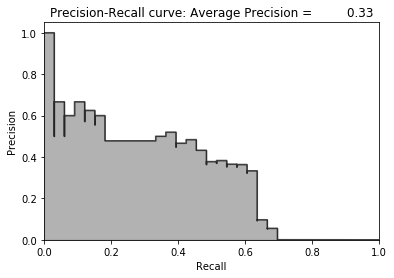

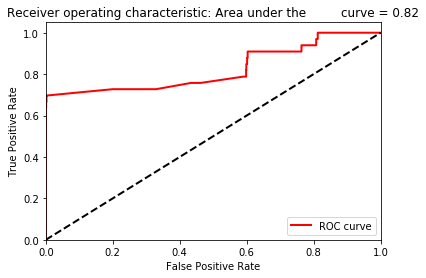

In [13]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

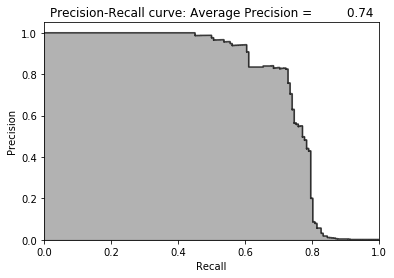

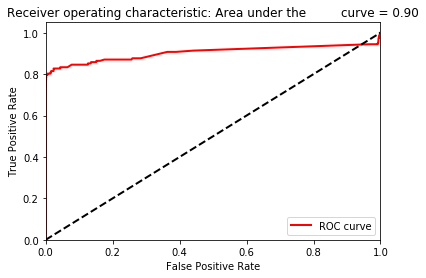

In [14]:
predictions = pd.Series(data=gbm.predict(X_test, \
                num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [15]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.5590909090909091


In [16]:
# 비지도 학습

In [17]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

In [18]:
model = Sequential()
model.add(Dense(units=40, activation='linear', \
                activity_regularizer=regularizers.l1(10e-5), \
                input_dim=29,name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [20]:
num_epochs = 5
batch_size = 32

history = model.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)


Train on 155058 samples, validate on 38765 samples
Epoch 1/5
155058/155058 [==============================] - 9s 60us/step - loss: 0.1294 - acc: 0.8701 - val_loss: 0.1263 - val_acc: 0.9534
Epoch 2/5
155058/155058 [==============================] - 9s 59us/step - loss: 0.0551 - acc: 0.9246 - val_loss: 0.0795 - val_acc: 0.9630
Epoch 3/5
155058/155058 [==============================] - 8s 53us/step - loss: 0.0461 - acc: 0.9246 - val_loss: 0.2303 - val_acc: 0.9569
Epoch 4/5
155058/155058 [==============================] - 8s 52us/step - loss: 0.0410 - acc: 0.9242 - val_loss: 0.2365 - val_acc: 0.9404
Epoch 5/5
155058/155058 [==============================] - 8s 53us/step - loss: 0.0396 - acc: 0.9225 - val_loss: 0.0618 - val_acc: 0.9773


190523/190523 [==============================] - 3s 16us/step


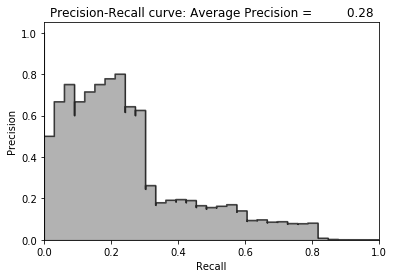

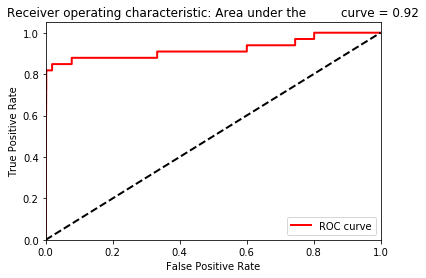

In [21]:
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, \
                                      anomalyScoresAETrain, True)

93987/93987 [==============================] - 1s 15us/step


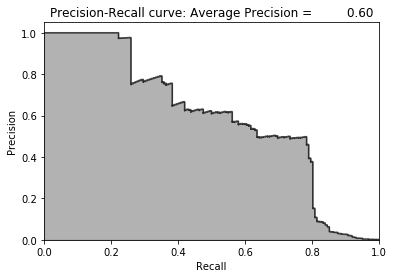

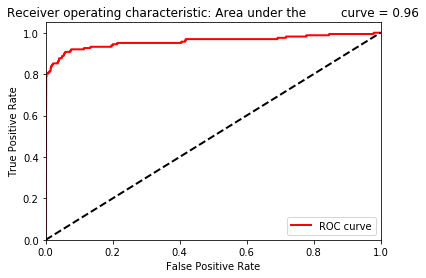

In [22]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

In [23]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.4939759036144578


In [24]:
# 준지도 학습

In [25]:
layer_name = 'hidden_layer'

intermediate_layer_model = Model(inputs=model.input, \
                                 outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test = intermediate_layer_model.predict(X_test_original)

In [26]:
intermediate_output_trainDF = \
    pd.DataFrame(data=intermediate_output_train,index=X_train_original.index)
intermediate_output_testDF = \
    pd.DataFrame(data=intermediate_output_test,index=X_test_original.index)

In [27]:
X_train = X_train_original.merge(intermediate_output_trainDF, \
                                 left_index=True,right_index=True)
X_test = X_test_original.merge(intermediate_output_testDF, \
                               left_index=True,right_index=True)
y_train = y_train_original.copy()

In [28]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, 
                                gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
            predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
                        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00568583
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00702315
[3]	valid_0's binary_logloss: 0.00411284
[4]	valid_0's binary_logloss: 0.00323353
[5]	valid_0's binary_logloss: 0.00318419
[6]	valid_0's binary_logloss: 0.00315916
[7]	valid_0's binary_logloss: 0.00314049
[8]	valid_0's binary_logloss: 0.00308838
[9]	valid_0's binary_logloss: 0.00306896
[10]	valid_0's binary_logloss: 0.00256963
[11]	valid_0's binary_logloss: 0.00256164
[12]	valid_0's binary_logloss: 0.00255407
[13]	valid_0's binary_logloss: 0.00254702
[14]	valid_0's binary_logloss: 0.00253785
[15]	valid_0's binary_logloss: 0.00252911
[16]	valid_0's binary_logloss: 0.00252085
[17]	valid_0's binary_logloss: 0.00251529
[18]	valid_0's binary_logloss: 0.00250791
[19]	valid_0's binary_logloss: 0.00250082
[20]	valid_0's binary_logloss: 0.00249404
[21]	valid_0's binary_logloss: 0.00248921
[22]	valid_0's binary_logloss: 0.00248103
[23]	valid_0's binary_

[201]	valid_0's binary_logloss: 0.0021322
[202]	valid_0's binary_logloss: 0.00213205
[203]	valid_0's binary_logloss: 0.00213075
[204]	valid_0's binary_logloss: 0.00212958
[205]	valid_0's binary_logloss: 0.00212841
[206]	valid_0's binary_logloss: 0.00212778
[207]	valid_0's binary_logloss: 0.00212679
[208]	valid_0's binary_logloss: 0.00212658
[209]	valid_0's binary_logloss: 0.00212644
[210]	valid_0's binary_logloss: 0.00212623
[211]	valid_0's binary_logloss: 0.00212603
[212]	valid_0's binary_logloss: 0.00212476
[213]	valid_0's binary_logloss: 0.00212464
[214]	valid_0's binary_logloss: 0.00212339
[215]	valid_0's binary_logloss: 0.00212215
[216]	valid_0's binary_logloss: 0.00212156
[217]	valid_0's binary_logloss: 0.00212036
[218]	valid_0's binary_logloss: 0.00211978
[219]	valid_0's binary_logloss: 0.00211855
[220]	valid_0's binary_logloss: 0.00211797
[221]	valid_0's binary_logloss: 0.00211693
[222]	valid_0's binary_logloss: 0.00211571
[223]	valid_0's binary_logloss: 0.0021153
[224]	valid_0

[122]	valid_0's binary_logloss: 0.00312444
[123]	valid_0's binary_logloss: 0.00312368
[124]	valid_0's binary_logloss: 0.00312365
[125]	valid_0's binary_logloss: 0.00312341
[126]	valid_0's binary_logloss: 0.00312306
[127]	valid_0's binary_logloss: 0.00312237
[128]	valid_0's binary_logloss: 0.00312223
[129]	valid_0's binary_logloss: 0.00312139
[130]	valid_0's binary_logloss: 0.00312141
[131]	valid_0's binary_logloss: 0.00312202
[132]	valid_0's binary_logloss: 0.00312185
[133]	valid_0's binary_logloss: 0.00312106
[134]	valid_0's binary_logloss: 0.00312111
[135]	valid_0's binary_logloss: 0.00312096
[136]	valid_0's binary_logloss: 0.00312035
[137]	valid_0's binary_logloss: 0.00311974
[138]	valid_0's binary_logloss: 0.00312031
[139]	valid_0's binary_logloss: 0.00311966
[140]	valid_0's binary_logloss: 0.00311956
[141]	valid_0's binary_logloss: 0.00312014
[142]	valid_0's binary_logloss: 0.00311954
[143]	valid_0's binary_logloss: 0.00312013
[144]	valid_0's binary_logloss: 0.00311956
[145]	valid

[110]	valid_0's binary_logloss: 0.00387368
[111]	valid_0's binary_logloss: 0.00387147
[112]	valid_0's binary_logloss: 0.00386853
[113]	valid_0's binary_logloss: 0.00386662
[114]	valid_0's binary_logloss: 0.00386419
[115]	valid_0's binary_logloss: 0.00386192
[116]	valid_0's binary_logloss: 0.00385997
[117]	valid_0's binary_logloss: 0.00385764
[118]	valid_0's binary_logloss: 0.00385518
[119]	valid_0's binary_logloss: 0.00385224
[120]	valid_0's binary_logloss: 0.00384919
[121]	valid_0's binary_logloss: 0.00384617
[122]	valid_0's binary_logloss: 0.00384315
[123]	valid_0's binary_logloss: 0.00384018
[124]	valid_0's binary_logloss: 0.00383722
[125]	valid_0's binary_logloss: 0.00383453
[126]	valid_0's binary_logloss: 0.00383178
[127]	valid_0's binary_logloss: 0.00382896
[128]	valid_0's binary_logloss: 0.0038261
[129]	valid_0's binary_logloss: 0.00382348
[130]	valid_0's binary_logloss: 0.0038208
[131]	valid_0's binary_logloss: 0.0038179
[132]	valid_0's binary_logloss: 0.00381572
[133]	valid_0'

[288]	valid_0's binary_logloss: 0.00198158
[289]	valid_0's binary_logloss: 0.00198157
[290]	valid_0's binary_logloss: 0.00198148
[291]	valid_0's binary_logloss: 0.00198158
[292]	valid_0's binary_logloss: 0.00198149
[293]	valid_0's binary_logloss: 0.00198013
[294]	valid_0's binary_logloss: 0.00198021
[295]	valid_0's binary_logloss: 0.0019799
[296]	valid_0's binary_logloss: 0.00198003
[297]	valid_0's binary_logloss: 0.00198007
[298]	valid_0's binary_logloss: 0.0019802
[299]	valid_0's binary_logloss: 0.00198014
[300]	valid_0's binary_logloss: 0.00197954
[301]	valid_0's binary_logloss: 0.00197949
[302]	valid_0's binary_logloss: 0.00197964
[303]	valid_0's binary_logloss: 0.00197907
[304]	valid_0's binary_logloss: 0.00197902
[305]	valid_0's binary_logloss: 0.00197966
[306]	valid_0's binary_logloss: 0.00197962
[307]	valid_0's binary_logloss: 0.00198026
[308]	valid_0's binary_logloss: 0.00198029
[309]	valid_0's binary_logloss: 0.00198093
[310]	valid_0's binary_logloss: 0.00198085
[311]	valid_0

[166]	valid_0's binary_logloss: 0.00296748
[167]	valid_0's binary_logloss: 0.00296506
[168]	valid_0's binary_logloss: 0.00296257
[169]	valid_0's binary_logloss: 0.00296018
[170]	valid_0's binary_logloss: 0.00295815
[171]	valid_0's binary_logloss: 0.00295571
[172]	valid_0's binary_logloss: 0.0029537
[173]	valid_0's binary_logloss: 0.00295171
[174]	valid_0's binary_logloss: 0.00294973
[175]	valid_0's binary_logloss: 0.00294776
[176]	valid_0's binary_logloss: 0.0029458
[177]	valid_0's binary_logloss: 0.00294386
[178]	valid_0's binary_logloss: 0.00294193
[179]	valid_0's binary_logloss: 0.00294001
[180]	valid_0's binary_logloss: 0.0029381
[181]	valid_0's binary_logloss: 0.00293621
[182]	valid_0's binary_logloss: 0.00293432
[183]	valid_0's binary_logloss: 0.00293245
[184]	valid_0's binary_logloss: 0.00293058
[185]	valid_0's binary_logloss: 0.00292873
[186]	valid_0's binary_logloss: 0.00292689
[187]	valid_0's binary_logloss: 0.00292506
[188]	valid_0's binary_logloss: 0.00292325
[189]	valid_0'

[362]	valid_0's binary_logloss: 0.00276853
[363]	valid_0's binary_logloss: 0.00276772
[364]	valid_0's binary_logloss: 0.00276756
[365]	valid_0's binary_logloss: 0.00276676
[366]	valid_0's binary_logloss: 0.00276661
[367]	valid_0's binary_logloss: 0.00276582
[368]	valid_0's binary_logloss: 0.00276568
[369]	valid_0's binary_logloss: 0.00276533
[370]	valid_0's binary_logloss: 0.00276519
[371]	valid_0's binary_logloss: 0.00276422
[372]	valid_0's binary_logloss: 0.00276389
[373]	valid_0's binary_logloss: 0.00276445
[374]	valid_0's binary_logloss: 0.00276501
[375]	valid_0's binary_logloss: 0.00276488
[376]	valid_0's binary_logloss: 0.00276412
[377]	valid_0's binary_logloss: 0.00276468
[378]	valid_0's binary_logloss: 0.00276456
[379]	valid_0's binary_logloss: 0.00276387
[380]	valid_0's binary_logloss: 0.00276356
[381]	valid_0's binary_logloss: 0.00276412
[382]	valid_0's binary_logloss: 0.002764
[383]	valid_0's binary_logloss: 0.00276333
[384]	valid_0's binary_logloss: 0.00276303
[385]	valid_0

[560]	valid_0's binary_logloss: 0.00272582
[561]	valid_0's binary_logloss: 0.00272565
[562]	valid_0's binary_logloss: 0.00272548
[563]	valid_0's binary_logloss: 0.00272517
[564]	valid_0's binary_logloss: 0.0027248
[565]	valid_0's binary_logloss: 0.00272449
[566]	valid_0's binary_logloss: 0.00272432
[567]	valid_0's binary_logloss: 0.00272402
[568]	valid_0's binary_logloss: 0.00272385
[569]	valid_0's binary_logloss: 0.00272355
[570]	valid_0's binary_logloss: 0.00272349
[571]	valid_0's binary_logloss: 0.00272383
[572]	valid_0's binary_logloss: 0.00272366
[573]	valid_0's binary_logloss: 0.00272349
[574]	valid_0's binary_logloss: 0.00272319
[575]	valid_0's binary_logloss: 0.00272314
[576]	valid_0's binary_logloss: 0.00272378
[577]	valid_0's binary_logloss: 0.00272361
[578]	valid_0's binary_logloss: 0.00272358
[579]	valid_0's binary_logloss: 0.00272341
[580]	valid_0's binary_logloss: 0.00272338
[581]	valid_0's binary_logloss: 0.00272334
[582]	valid_0's binary_logloss: 0.00272297
[583]	valid_

[755]	valid_0's binary_logloss: 0.00272
[756]	valid_0's binary_logloss: 0.00271974
[757]	valid_0's binary_logloss: 0.00271944
[758]	valid_0's binary_logloss: 0.00271962
[759]	valid_0's binary_logloss: 0.00271971
[760]	valid_0's binary_logloss: 0.00271974
[761]	valid_0's binary_logloss: 0.00271948
[762]	valid_0's binary_logloss: 0.0027199
[763]	valid_0's binary_logloss: 0.00271961
[764]	valid_0's binary_logloss: 0.00272009
[765]	valid_0's binary_logloss: 0.00272028
[766]	valid_0's binary_logloss: 0.00272001
[767]	valid_0's binary_logloss: 0.00271972
[768]	valid_0's binary_logloss: 0.00271982
[769]	valid_0's binary_logloss: 0.0027203
[770]	valid_0's binary_logloss: 0.00271965
[771]	valid_0's binary_logloss: 0.00271983
[772]	valid_0's binary_logloss: 0.00271954
[773]	valid_0's binary_logloss: 0.00271963
[774]	valid_0's binary_logloss: 0.00271898
[775]	valid_0's binary_logloss: 0.0027186
[776]	valid_0's binary_logloss: 0.0027187
[777]	valid_0's binary_logloss: 0.00271873
[778]	valid_0's bi

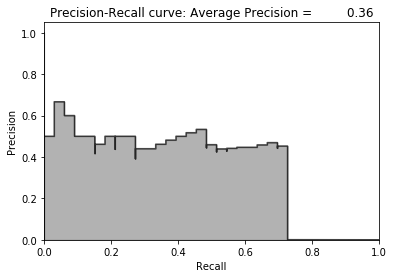

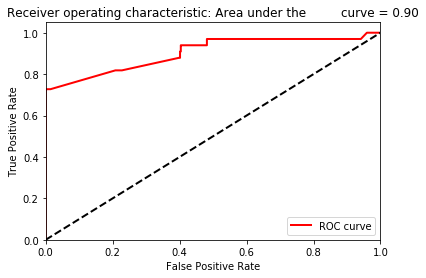

In [29]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

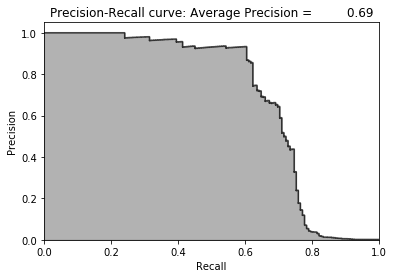

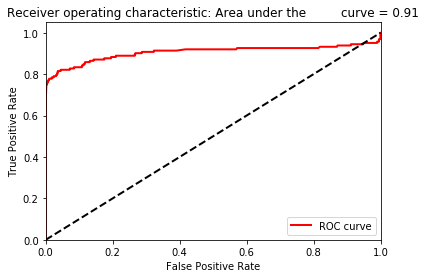

In [30]:
predictions = pd.Series(data=gbm.predict(X_test, \
                    num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [31]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(precision)

0.23929961089494164


In [32]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), \
                        index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', \
                               ascending=False,inplace=True)
featuresImportance

,featImportance
V25,0.123744
V12,0.067005
4,0.059388
2,0.052986
V21,0.049895
...,...
18,0.000110
39,0.000110
V24,0.000000
30,0.000000
